In [1]:
import numpy as np
import time
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import register, execute

# import backend utilities
from qiskit.backends import JobStatus

# import tomography library
import qiskit.tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state
from qiskit.tools.qi.qi import *
from qiskit.wrapper.jupyter import *
from qiskit.backends.ibmq import least_busy
from CircuitTransitionGraph import *

# import state tomography functions
from qiskit.tools.visualization import plot_histogram, plot_state
from parseRealization import *
%matplotlib inline
global testDir

    
testDir="./tests/"

In [2]:
IBMQ.save_account('f5819f434faf55109be4d80d68984a810895c78102f2702d2851169dc7f9aa18ac03ce2e357e896df27f59455cc0f897faf4ab6ee599c2f23a16f01f521fbfb2')


/home/george/.local/lib/python3.6/site-packages/qiskit/backends/ibmq/ibmqprovider.py:141: UserWarning: Credentials are already stored.
  warnings.warn('Credentials are already stored.')


In [3]:
# Load saved IBMQ accounts
start = time.time()
IBMQ.load_accounts()
end = time.time()
print(end-start)
#available = IBMQ.backends(operational=True, simulator=False)
#print(available)
start = time.time()
print(-end+start)
#least_busy = least_busy(available)


least_busy = IBMQ.get_backend('ibmq_16_melbourne')


end = time.time()
print(end-start)

couplingMap = least_busy.configuration()["coupling_map"]
start = time.time()
print(-end+start)
qubitsSize = least_busy.configuration()["n_qubits"]

1.030980110168457
0.00012159347534179688
0.00015473365783691406
0.00010180473327636719


In [4]:
def flipTheString(s):
    myString=""
    length = len(s)
    for it in range(0,length):
        myString=myString+s[length-1-it]
    return myString

In [5]:
def testFromFile(fileName,details=0):
    fileName1 = testDir+fileName + ".real"
    fileName2 = testDir+fileName + ".pla"
    global ctg
    size = readSizeFromFile(fileName1)
    answers = readKmapFromFile(fileName2)
    errors=[]
    error_count = 0
    backend_sim = Aer.get_backend('qasm_simulator')
    for i in answers:
        qr = QuantumRegister(qubitsSize)
        cr = ClassicalRegister(qubitsSize)
        qc = QuantumCircuit(qr,cr)

        for j in range(0,size):
            if i[j]=="1":
                qc.x(qr[j])
        qc,qr,ctg = readGatesFromFile(fileName1,qc,qr)
        qc.measure(qr,cr)
        job_sim = execute(qc, backend_sim)#,config)
        stats_sim = job_sim.result().get_counts()
        if details==1:
            # circuit_drawer(qc) won't work, why though
            print(i,stats_sim)
        for release in stats_sim:
            myString = flipTheString(release)
            if myString != answers[i]:
                error = i + ":" + myString + ":"+answers[i]
                errors = errors + [error]
                error_count = error_count+1
    if error_count != 0 :
        print("FAILURE")
    if details==1:
        print(qc.qasm())
        #quasmToMatlab(qc.qasm())
        print("Input:Received:Expected")
        for item in errors:
            print(item)
        print(answers)
        print("ERROR:",error_count)
    return error_count
            #plot_histogram(stats_sim)

In [6]:
def bigFunction(fileName):
    ctg = CircuitTransitionGraph()
    ctg = buildCGraph(fileName,ctg)
    ctg = measureFidelityWithoutChanges(fileName,ctg)
    ctg = fixTheStuff(ctg)
    ctg = measureFidelityWithChanges(fileName,ctg)

def fixTheStuff(ctg):
    print("Missing connections are",ctg.getMissingConnections())
    ctg.fixMissingEdges()
    print("FIxing the stuff")
    print(ctg.getLines())
    return ctg
    
def buildCGraph(fileName,ctg):
    fileName1 = testDir+fileName + ".real"
    fileName2 = testDir+fileName + ".pla"
    ctg = readGatesFromFile(fileName1,ctg)
    print(ctg.transformCoupling(couplingMap))
    print(ctg)
    print(ctg.getLines())
    return ctg
    
def measureFidelityWithoutChanges(fileName,ctg):
    #least_busy = Aer.get_backend('qasm_simulator')
    fileName1 = testDir+fileName + ".real"
    fileName2 = testDir+fileName + ".pla"
    size = readSizeFromFile(fileName1)
    answers = readKmapFromFile(fileName2)
    keys = list(answers.keys())
    subList = keys[:]
    print (subList)
    for i in subList:
        print("Not Fixed",i)
        qr = QuantumRegister(size)
        cr = ClassicalRegister(size)
        qc = QuantumCircuit(qr,cr)

        for j in range(0,size):
            if i[j]=="1":
                qc.x(qr[j])

        qc,qr = readGatesFromCtgNoMod(qc,qr,ctg)
        qc.measure(qr,cr)
        job = execute(qc,least_busy,shots=200)
        result = job.result()
        print(result.get_counts())
        plot_histogram(result.get_counts())
        #print (qc.qasm())
    return ctg
    
def measureFidelityWithChanges(fileName,ctg):
    #least_busy = Aer.get_backend('qasm_simulator')
    #part with
    fileName1 = testDir+fileName + ".real"
    fileName2 = testDir+fileName + ".pla"
    size = readSizeFromFile(fileName1)
    answers = readKmapFromFile(fileName2)
    keys = list(answers.keys())
    subList = keys[:]
    print (subList)
    for i in subList:
        print("Fixed",i)
        qr = QuantumRegister(size)
        cr = ClassicalRegister(size)
        qc = QuantumCircuit(qr,cr)

        for j in range(0,size):
            if i[j]=="1":
                qc.x(qr[j])

        qc,qr = readGatesFromCtg(qc,qr,ctg)
        qc.measure(qr,cr)
        job = execute(qc,least_busy,shots=200)
        result = job.result()
        print(result.get_counts())
        plot_histogram(result.get_counts())
        #print (qc.qasm())

{'b': {'n', 'a', 'c'}, 'a': {'b'}, 'c': {'m', 'd', 'b'}, 'd': {'e', 'c', 'l'}, 'e': {'k', 'd', 'f'}, 'k': {'j', 'e', 'l'}, 'f': {'g', 'j', 'e'}, 'g': {'i', 'f'}, 'j': {'i', 'k', 'f'}, 'i': {'h', 'j', 'g'}, 'h': {'i'}, 'l': {'k', 'm', 'd'}, 'm': {'n', 'c', 'l'}, 'n': {'m', 'b'}}
Weights are:{'bc': 3, 'ac': 1}, skeleton is:['bc', 'bc', 'ac', 'bc'], vertices are{'a', 'c', 'b'}, paths are {},latest weight are[]
['t3 b c a\n', 't2 c b\n', 't2 b c\n', 't2 a c\n', 't2 c b\n']
['000', '001', '010', '011', '100', '101', '110', '111']
Not Fixed 000
{'000': 91, '010': 16, '100': 34, '110': 11, '001': 11, '011': 13, '101': 9, '111': 15}


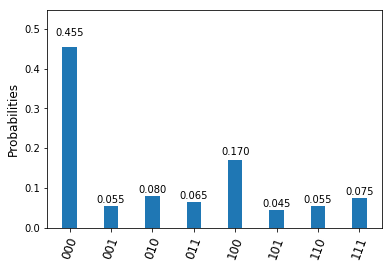

Not Fixed 001
{'000': 25, '001': 18, '100': 6, '101': 43, '010': 75, '011': 10, '110': 8, '111': 15}


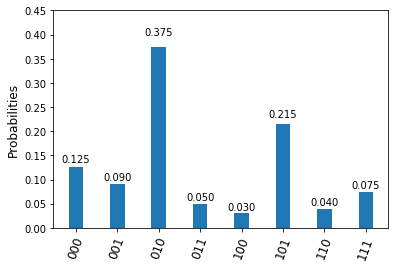

Not Fixed 010
{'000': 46, '010': 10, '100': 90, '110': 16, '001': 9, '011': 16, '101': 4, '111': 9}


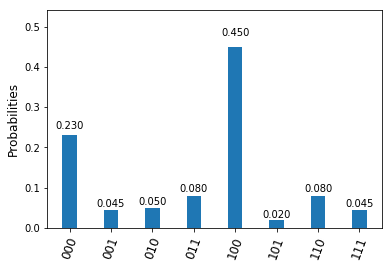

Not Fixed 011
{'000': 16, '001': 72, '010': 24, '011': 36, '100': 12, '101': 10, '110': 19, '111': 11}


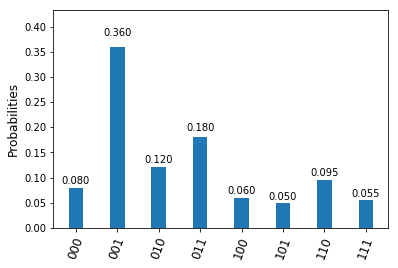

Not Fixed 100
{'000': 37, '001': 9, '100': 19, '101': 13, '010': 6, '011': 16, '110': 17, '111': 83}


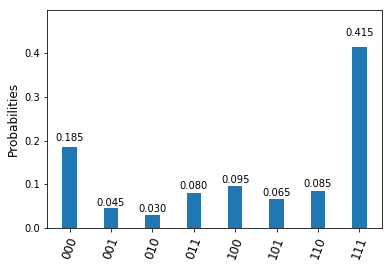

Not Fixed 101
{'000': 5, '010': 14, '100': 16, '110': 7, '001': 22, '011': 8, '101': 115, '111': 13}


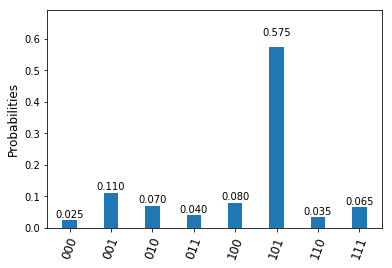

Not Fixed 110
{'000': 15, '001': 28, '100': 39, '101': 14, '010': 11, '011': 58, '110': 15, '111': 20}


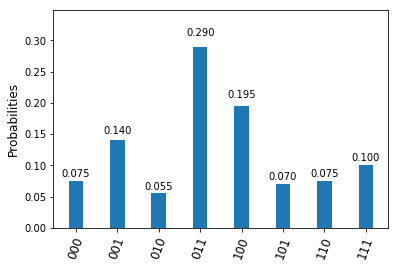

Not Fixed 111
{'000': 17, '001': 32, '100': 26, '101': 23, '010': 10, '011': 14, '110': 62, '111': 16}


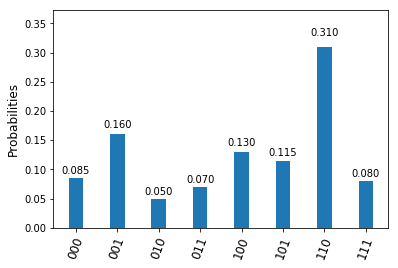

Self skeleton is ['bc', 'bc', 'ac', 'bc']
Missing connections are [['a', 'c']]
b
a
c
d
e
k
f
g
j
i
h
l
m
n
Paths to a c
Trace is
[['a', 'b', 'n', 'm', 'c'], ['a', 'b', 'n', 'm', 'l', 'k', 'j', 'i', 'g', 'f', 'e', 'd', 'c'], ['a', 'b', 'n', 'm', 'l', 'k', 'j', 'f', 'e', 'd', 'c'], ['a', 'b', 'n', 'm', 'l', 'k', 'e', 'd', 'c'], ['a', 'b', 'n', 'm', 'l', 'd', 'c'], ['a', 'b', 'c']]
['c', 'b'] ['a', 'c']
['b', 'c'] ['a', 'c']
['a', 'c'] ['a', 'c']
replaceTo ['a', 'b', 'c']
sw a b
['a', 'b']
fixed skeleton ['bc', 'bc', 'ab', 'bc']
FIxing the stuff
['t3 b c a\n', 't2 c b\n', 't2 b c\n', 'sw a b', 't2 b c', 'sw a b', 't2 c b\n']
['000', '001', '010', '011', '100', '101', '110', '111']
Fixed 000
{'000': 54, '001': 16, '010': 30, '011': 27, '100': 15, '101': 20, '110': 25, '111': 13}


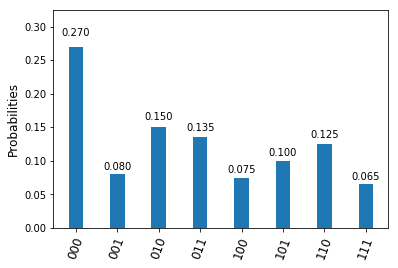

Fixed 001
{'000': 42, '001': 17, '010': 51, '011': 13, '100': 15, '101': 17, '110': 26, '111': 19}


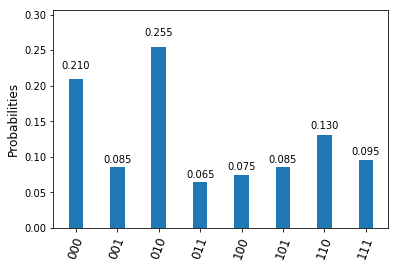

Fixed 010
{'000': 40, '001': 21, '010': 44, '011': 28, '100': 31, '101': 12, '110': 12, '111': 12}


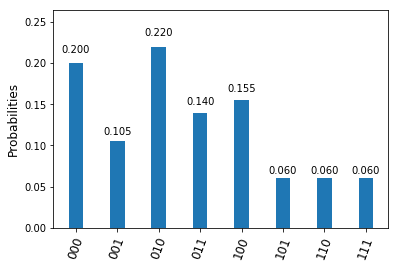

Fixed 011
{'000': 37, '001': 28, '010': 50, '011': 15, '100': 15, '101': 19, '110': 20, '111': 16}


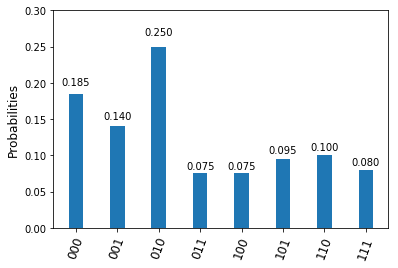

Fixed 100
{'000': 37, '001': 30, '010': 21, '011': 16, '100': 19, '101': 21, '110': 14, '111': 42}


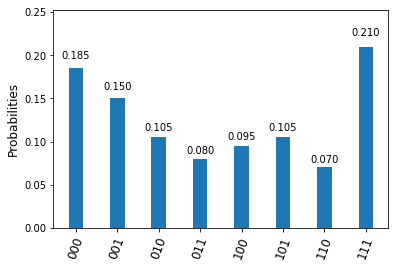

Fixed 101
{'000': 23, '001': 32, '010': 27, '011': 27, '100': 11, '101': 30, '110': 11, '111': 39}


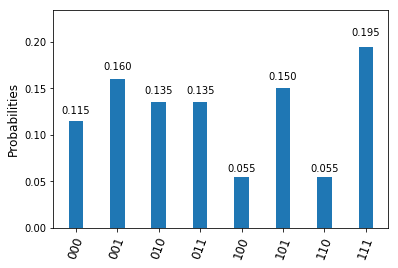

Fixed 110
{'000': 29, '001': 21, '010': 29, '011': 48, '100': 16, '101': 16, '110': 22, '111': 19}


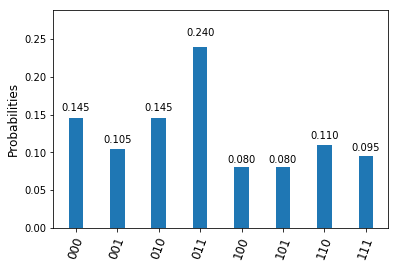

Fixed 111
{'000': 19, '001': 37, '010': 24, '011': 16, '100': 25, '101': 27, '110': 30, '111': 22}


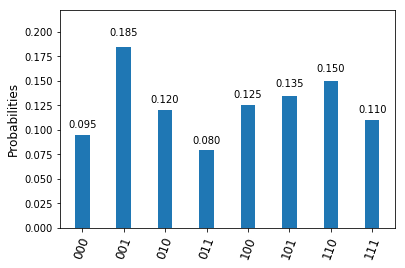

In [7]:
fileName="ham3_28"
#if testFromFile(filename) == 0:
bigFunction(fileName)
